In [1]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [3]:
DEVICE

device(type='cuda', index=0)

In [4]:
n = 1024
x = torch.randn(n,n)

In [5]:
def simple_softmax(x):
    # returns values at index 0 and indices at index 1
    x_max = x.max(dim=1)[0]

    # have to convert x_max to row vector so it broadcasts properly
    z = x - x_max.view(-1, 1)

    num = torch.exp(z)
    denom = num.sum(dim=1)

    ret = num/denom.view(-1, 1)

    return ret

In [6]:
%timeit simple_softmax(x)

1.24 ms ± 26.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%timeit torch.softmax(x, dim=1)

424 μs ± 1.11 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
x = x.to(DEVICE)
%timeit torch.softmax(x, dim=1)

81.1 μs ± 369 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
@triton.jit
def softmax_kernel(outptr, inptr, input_row_stride, output_row_stride,  n_rows, n_cols, block_size: tl.constexpr, n_stages: tl.constexpr):
    row_start = tl.program_id(0)

    # programs per block??
    row_step = tl.num_programs(0)

    # range(start, end, step, num_stages)
    # stages is basically interleaving the data loading with the computation so GPU doesnt sit idle
    for row_idx in tl.range(row_start, n_rows, row_step, n_stages):

        # stride represents how much to increase the ptr to next row
        row_start_ptr = inptr + row_idx * input_row_stride

        col_offsets = tl.arange(0, block_size)

        # block_size is the number of blocks being operated on (load,store) by GPU.
        # it needs to be a power of 2.

        # input_row_stride is how many elements it needs to skip to reach the next row (number of cols basically)
        # that's why we have them separate

        inptrs = row_start_ptr + col_offsets
        mask = col_offsets < n_cols

        # neg infinity because e^-inf = 0
        row = tl.load(inptrs, mask=mask, other=-float('inf'))

        # axis 0 because we are plucking out a single row vector, so no need for reshape or dim specification
        row_stable = row - tl.max(row, axis=0)

        numerator = tl.exp(row_stable)
        denom = tl.sum(numerator, axis=0)
        op = numerator/denom

        # output row stride diff from input because i guess sometimes they are different
        out_start_ptr = outptr + row_idx * output_row_stride
        out_ptrs = out_start_ptr + col_offsets
        tl.store(out_ptrs, op, mask=mask)

In [10]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
properties

{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 16,
 'warpSize': 32,
 'sm_clock_rate': 1455000,
 'mem_clock_rate': 7001000,
 'mem_bus_width': 64}

In [11]:
 triton.runtime.driver.active.get_current_target().backend

'cuda'

In [12]:
def softmax(x):
    n_rows, n_cols = x.shape

    block_size = triton.next_power_of_2(n_cols)

    # warps per block
    # different from warpsize which defines how many threads per warp
    num_warps = max(1, block_size//32)

    num_warps = min(num_warps, 32)
    num_stages = 1

    if block_size > 4096:
        block_size = 4096
        num_warps = 32

    y = torch.empty_like(x)
    
    # grid is (1,) because we are just warming up the kernel
    # first execution takes longer due to compilation
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size=block_size, n_stages = num_stages,
                                    num_warps = num_warps, grid = (1,))

    kernel._init_handles()

    # registers used per thread
    n_regs = kernel.n_regs

    # how much memory shared per block
    size_smem = kernel.metadata.shared

    # how many registers are occupied
    # num_warps warps per block * total threads per warp * registers per thread
    occupancy = properties["max_num_regs"] // (n_regs * properties["warpSize"] * num_warps)

    # shared mem constraint
    occupancy = min(occupancy, properties["max_shared_mem"] // size_smem)

    # total block capacity and total required blocks
    num_programs = properties["multiprocessor_count"] * occupancy
    num_programs = min(num_programs, n_rows)

    
    kernel[(num_programs,1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size, num_stages)
    return y

In [13]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

In [14]:
%timeit torch.softmax(x, axis=1)

112 μs ± 1.41 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%timeit softmax(x)

201 μs ± 1.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
# 4x speedup using kernel because instead of multiple reads/writes
# we only read/write n_rows * n_cols bytes
%timeit simple_softmax(x)

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
97.3 μs ± 53.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


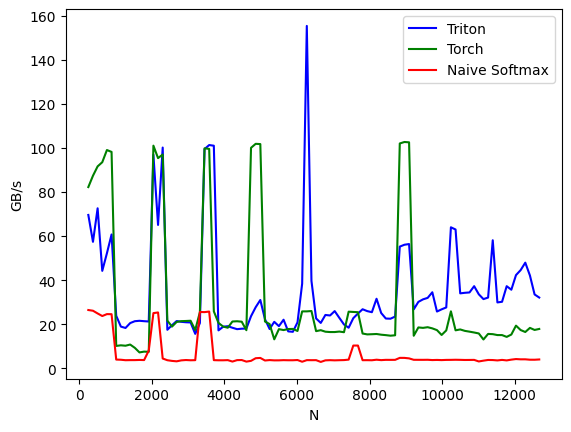

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0   69.610019   82.248995      26.477053
1     384.0   57.420561   87.396868      26.158952
2     512.0   72.622100   91.633108      24.920818
3     640.0   44.255318   93.523988      23.753931
4     768.0   52.226677   99.046852      24.625250
5     896.0   60.745762   98.191779      24.590051
6    1024.0   23.883382   10.195395       4.007828
7    1152.0   18.962963   10.472727       3.925879
8    1280.0   18.334825   10.286288       3.714856
9    1408.0   20.554745   10.820365       3.755293
10   1536.0   21.407665    9.330296       3.759698
11   1664.0   21.594427    7.252246       3.831894
12   1792.0   21.414449    7.612228       3.781552
13   1920.0   21.274238    7.524767       8.085730
14   2048.0   96.902639  101.039850      25.076089
15   2176.0   65.069034   95.386300      25.376093
16   2304.0  100.173911   97.010523       4.482490
17   2432.0   17.512151   21.665924       3.706611
18   2560.

<Figure size 640x480 with 0 Axes>

In [17]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: simple_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True, save_path='./tests')
plt.show()